## Cross-Platform Latent Connectivity Detection using the Temporal Dimension

### Social Media Usecase

Not all connections between individuals are apparent in the structural network data we have access to. One example to such scenario is when individuals employ different platforms of communications, which inherently lack inter-platform connections.

In this demo, we demonstrate the ability to match profiles across separate platforms, despite the absence of explicit connections between them.
We introduce the concept of an individual's temporal fingerprint, defined by the time gaps between consecutive activities (inter-event time distribution), and find that profiles present similar temporal fingerprints across different social domains.

This methodology uses merely the temporal metadata of users' activity, and does not require access to network structure or user generated content. As such, it can be employed on any type of temporal dataset, including encrypted domains.

**Overview**
1. Loading the data
2. Preprocessing
3. Visualizations
4. Evaluation

**Files:**
1. posts.csv: raw metadata of posting activity (see Section 1: Loading the data)
2. tagged_communities: labeled data of true communities of collaborators


**Data Labeling**

We label a group of profiles as belonging to the same community if their profile names, biographies, or public activity indicate they belong to, represent, or work under the same organization. The matching process included surfacing pairs of profiles - typically organizations - with very similar names, and affirming their relationship manually by reviewing their respective profiles. Additionally, we searched for and included affilliates and subsidiaries of organizations, which we found via biographical information, although those account for a small portion of the data.

Examples of communities:
1. [(@company1, twitter), (@company1, telegram)]
2. [(@company2_worker1, instagram), (@company2_worker2, telegram), (@company2_worker3, twitter)]

**Data Disclaimer**

The data was scraped and provided by a third party and carefully tagged using the guidelines above.

**Citation**

If you find our work useful, please kindly consider citing the original paper: https://arxiv.org/pdf/2407.04350

### Loading the Data

The dataset includes posting activity metadata collected over the span of 18 days from various social media platforms such as twitter (X), telegram, and instagram. The schema:
- "creator_name" (string): encryped name of the profile that posted 
- "platform_type" (string): the social platform to which the profile belongs
- "creation_time" (string): the date and time at which the post was created, in the format of %Y-%m-%d %H:%M:%S

*Note: a 'user' is defined as a unique pair of "creator_name" and "platform_type".*

In [1]:
import pandas as pd
from scipy.stats import ks_2samp
from typing import List
from tslearn.metrics import dtw
import matplotlib.pyplot as plt
import seaborn as sns


/Users/tom/anaconda3/envs/intereventsim/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
# load the post metadata
TIME_PERIOD = ("2024-06-08", "2024-06-15")
posts_df = pd.read_csv("posts_identity_matching_masked_v2.csv", index_col=0)
posts_df = posts_df[posts_df["creation_time"].between(*TIME_PERIOD)]

# save column names as constants
PROFILE_COL_NAME, PLATFORMS_COL_NAME, CREATION_TIMES_COL_NAME, LABEL_COL = posts_df.columns

posts_df

,creator_name,platform_type,creation_time,label
2,5389646ea08918451bdc1763a116fe00b1f1f19e32ea18...,twitter,2024-06-12 04:01:19,1
3,4266703c597aba236d63a369c11638b36c134cced513ff...,twitter,2024-06-12 10:19:15,0
7,175d885203a019baa12ff49533e3f8e38ed553d2f1f04d...,twitter,2024-06-13 14:26:04,7
9,cac7b79b7eca7236f513ac494ee2190c32aa9e69c323a2...,telegram,2024-06-08 12:38:33,10
10,48b8e55428ffcd743a5ed414af8fc20035b84f9180cce2...,telegram,2024-06-10 13:12:34,3
...,...,...,...,...
114402,ac2cdc3e099d9657985d935346ae5d7db86f3ad01ba279...,telegram,2024-06-09 04:08:23,13
114403,5389646ea08918451bdc1763a116fe00b1f1f19e32ea18...,twitter,2024-06-11 17:14:30,1
114407,5389646ea08918451bdc1763a116fe00b1f1f19e32ea18...,twitter,2024-06-14 12:59:23,1
114411,0e905501ddd06938daa337f1fef611c5d20f9c4961a38a...,telegram,2024-06-13 06:49:15,12


### Preprocessing

To extract communities from the data, we'll first need to establish and evaluate the relationship between each pair of users.

That includes a few simple steps:

0. (Type casting)
1. Grouping activity per user
2. Computing the silence periods between each of the user's posts
3. Computing the Kolmogorov-Smirnov distance between each pair of users

In [3]:
# Convert string timestamps into datetime type
posts_df[CREATION_TIMES_COL_NAME] = pd.to_datetime(posts_df[CREATION_TIMES_COL_NAME])

In [4]:
min_time = posts_df[CREATION_TIMES_COL_NAME].min()
posts_df["time_from_start"] = (posts_df[CREATION_TIMES_COL_NAME] - min_time).dt.total_seconds()
posts_df.head()

,creator_name,platform_type,creation_time,label,time_from_start
2,5389646ea08918451bdc1763a116fe00b1f1f19e32ea18...,twitter,2024-06-12 04:01:19,1,352575.0
3,4266703c597aba236d63a369c11638b36c134cced513ff...,twitter,2024-06-12 10:19:15,0,375251.0
7,175d885203a019baa12ff49533e3f8e38ed553d2f1f04d...,twitter,2024-06-13 14:26:04,7,476460.0
9,cac7b79b7eca7236f513ac494ee2190c32aa9e69c323a2...,telegram,2024-06-08 12:38:33,10,38009.0
10,48b8e55428ffcd743a5ed414af8fc20035b84f9180cce2...,telegram,2024-06-10 13:12:34,3,212850.0


#### Computing Silence Periods

A silence period is a period of time that elapsed between two consecutive events. In our case, we will define it as the time, in seconds between each posts by the same user.

*(Note: Since we later plot the silence period distributions on a log-log scale, we add a precautionary 1 second to all silence periods to avoid a log(0) value)*

In [5]:
# sort posting times per user
posts_df = posts_df.sort_values([PROFILE_COL_NAME, PLATFORMS_COL_NAME, CREATION_TIMES_COL_NAME])

def aggregate_and_compute_silence_periods(user_data: pd.DataFrame) -> pd.Series:
    """Compute inter-event periods and collect information per user"""
    
    silence_periods = user_data[CREATION_TIMES_COL_NAME].diff().dt.total_seconds().add(1).dropna().tolist()
    creation_times = user_data[CREATION_TIMES_COL_NAME].tolist()
    time_from_start = user_data['time_from_start'].tolist()
    label = user_data['label'].tolist()[0]
    return pd.Series([creation_times, silence_periods, time_from_start, label])

grouped_df = posts_df.groupby([PROFILE_COL_NAME, PLATFORMS_COL_NAME]).apply(aggregate_and_compute_silence_periods)
grouped_df.columns = ["creation_times", "silence_periods", "time_from_start", "label"]

grouped_df.head(5)

/var/folders/zc/b62gpf_j6_xfkbm72shby5gm0000gn/T/ipykernel_50752/2906892783.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df = posts_df.groupby([PROFILE_COL_NAME, PLATFORMS_COL_NAME]).apply(aggregate_and_compute_silence_periods)


creation_times  \
creator_name                                       platform_type                                                      
01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618fd... twitter        [2024-06-08 03:26:59, 2024-06-08 03:28:35, 202...   
06cc0863f27cff52aef1e0e084c55bdc91cf6d3ee99e740... twitter        [2024-06-08 05:19:39, 2024-06-08 06:00:18, 202...   
091dd46487eb1852205ccb85e692aee074fcb9b6cdcb393... telegram       [2024-06-08 03:52:00, 2024-06-08 03:58:53, 202...   
                                                   twitter        [2024-06-08 05:19:39, 2024-06-08 05:21:16, 202...   
0e905501ddd06938daa337f1fef611c5d20f9c4961a38a9... telegram       [2024-06-08 02:11:32, 2024-06-08 02:26:41, 202...   

                                                                                                    silence_periods  \
creator_name                                       platform_type                                                      
01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618fd... twitter        [97.0, 98.0, 46.0, 52.0, 120.0, 80.0, 316.0, 6...   
06cc0863f27cff52aef1e0e084c55bdc91cf6d3ee99e740... twitter        [2440.0, 16192.0, 18590.0, 635.0, 1549.0, 1822...   
091dd46487eb1852205ccb85e692aee074fcb9b6cdcb393... telegram       [414.0, 1910.0, 2895.0, 1428.0, 5594.0, 640.0,...   
                                                   twitter        [98.0, 721.0, 1623.0, 5478.0, 2301.0, 390.0, 1...   
0e905501ddd06938daa337f1fef611c5d20f9c4961a38a9... telegram       [910.0, 899.0, 588.0, 55.0, 36.0, 855.0, 1104....   

                                                                                                    time_from_start  \
creator_name                                       platform_type                                                      
01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618fd... twitter        [4915.0, 5011.0, 5108.0, 5153.0, 5204.0, 5323....   
06cc0863f27cff52aef1e0e084c55bdc91cf6d3ee99e740... twitter        [11675.0, 14114.0, 30305.0, 48894.0, 49528.0, ...   
091dd46487eb1852205ccb85e692aee074fcb9b6cdcb393... telegram       [6416.0, 6829.0, 8738.0, 11632.0, 13059.0, 186...   
                                                   twitter        [11675.0, 11772.0, 12492.0, 14114.0, 19591.0, ...   
0e905501ddd06938daa337f1fef611c5d20f9c4961a38a9... telegram       [388.0, 1297.0, 2195.0, 2782.0, 2836.0, 2871.0...   

                                                                  label  
creator_name                                       platform_type         
01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618fd... twitter            0  
06cc0863f27cff52aef1e0e084c55bdc91cf6d3ee99e740... twitter            8  
091dd46487eb1852205ccb85e692aee074fcb9b6cdcb393... telegram           8  
                                                   twitter            8  
0e905501ddd06938daa337f1fef611c5d20f9c4961a38a9... telegram          12

In [6]:
# [Optional] Filter based on minimum activity, in our case, about one post per day
MINIMUM_ACTIVITY = 20
grouped_df = grouped_df[grouped_df["creation_times"].apply(len) >= MINIMUM_ACTIVITY]

#### Computing the KS (Kolmogorov–Smirnov) distance

The [Kolmogorov–Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) is a nonparametric test for determining whether two samples of data came from the same distribution, or in the other words, the likelihood of observing the two samples of data given that they were drawn from the same probability distribution.

The outcome (statistic) of the test is the maximum distance per value observed between the two provided empirical distributions:

<img src="ks-statistic-illustration.png" alt="KS statistic illustration" style="width: 200px;"/>

We will employ this test to evaluate the similarity between the inter-event time distributions of every pair of users, where lower KS values indicate closer distributions. Our hypothesis is that community members will have similar inter-event time distributions.

*Note: for large datasets, we recommend using a parallelized framework like Spark instead of pandas*

In [7]:

N = len(grouped_df)
ks_results = []

# compare every pair of users, skipping symmetrical and self comparisons
for i in range(N):
    for j in range(i+1, N):
        user1 = grouped_df.iloc[i]
        user2 = grouped_df.iloc[j]
        if user1.name[1] == user2.name[1]:
            continue
        sp1 = user1.silence_periods
        sp2 = user2.silence_periods
        
        # compute the KS statistic
        ks, p_val = ks_2samp(sp1, sp2)
        ks_results.append((*user1.name, *user2.name, float(ks), float(p_val), user1.label == user2.label))

ks_results = pd.DataFrame(
    ks_results,
    columns=[
        PROFILE_COL_NAME + "_1",
        PLATFORMS_COL_NAME + "_1",
        PROFILE_COL_NAME + "_2",
        PLATFORMS_COL_NAME + "_2",
        "statistic",
        "p_val",
        "correct"
    ]
)
ks_results.head(5)

,creator_name_1,platform_type_1,creator_name_2,platform_type_2,statistic,p_val,correct
0,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,091dd46487eb1852205ccb85e692aee074fcb9b6cdcb39...,telegram,0.592443,6.297080e-62,False
1,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,0e905501ddd06938daa337f1fef611c5d20f9c4961a38a...,telegram,0.366883,4.691081e-62,False
2,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,175d885203a019baa12ff49533e3f8e38ed553d2f1f04d...,telegram,0.153174,2.044515e-13,False
3,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,2af1863322e5ff7bca144acc446f41a60f9f4b08067732...,telegram,0.735993,9.788205e-62,False
4,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,48b8e55428ffcd743a5ed414af8fc20035b84f9180cce2...,telegram,0.104647,8.870734e-10,False


In [8]:
ks_results = ks_results.sort_values('statistic')
ks_results

,creator_name_1,platform_type_1,creator_name_2,platform_type_2,statistic,p_val,correct
87,175d885203a019baa12ff49533e3f8e38ed553d2f1f04d...,telegram,175d885203a019baa12ff49533e3f8e38ed553d2f1f04d...,twitter,0.024202,9.351088e-01,True
236,5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bca...,telegram,fef3b4e0bc9e8a76779b5e341d6e11ba916c24e149fee3...,twitter,0.034309,2.276064e-01,True
327,c254ff70dd51e6a0b3c117a631a30a23ba2f7a56a81872...,telegram,e7430e901370dfe1261df560c6a25570a228eeeb7df067...,twitter,0.037867,9.327102e-01,True
6,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bca...,telegram,0.038672,1.215306e-01,True
164,4266703c597aba236d63a369c11638b36c134cced513ff...,twitter,5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bca...,telegram,0.039001,1.149935e-01,True
...,...,...,...,...,...,...,...
28,06cc0863f27cff52aef1e0e084c55bdc91cf6d3ee99e74...,twitter,b88a62af2a90360538840b46d759e122d306bb051b9d87...,telegram,0.867780,2.101437e-41,False
182,48b8e55428ffcd743a5ed414af8fc20035b84f9180cce2...,telegram,c677237cedd54f37e261f59f3c6a55608f227b61348821...,twitter,0.875472,4.001580e-95,False
230,5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bca...,telegram,c677237cedd54f37e261f59f3c6a55608f227b61348821...,twitter,0.878327,3.338150e-95,False
63,091dd46487eb1852205ccb85e692aee074fcb9b6cdcb39...,twitter,b88a62af2a90360538840b46d759e122d306bb051b9d87...,telegram,0.878428,1.395376e-154,False


### Analysis & Evaluation

Now that we have computed the KS-distance for every pair of users, we will use it to determine communities among users.

#### Benchmarking: Dynamic Time-Warping

A well-known measurement of similarity between two temporal sequences, [Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping) finds how similar two sets of sequenctial data by finding the least 'costly' match between them.

We will use the DTW similarity as a benchmark for the normalized KS statistic and check whether it can be used to find the communities we have correctly identified.

To do that, we will use a similar process to what we have done so far, but *within the communities we have detected*:
1. Apply DTW and compute the similarity between silence periods of all *strong pairs* previously found()
2. Reconstruct the graph using the DTW similarity as the edge between every two nodes
3. Use the louvain algorithm to extract communities
4. Compare results

In [ ]:
def create_edge_list_from_dataframe(df: pd.DataFrame, weighted=False, weight_col=None) -> List:
    """
    Create an edgelist from dataframe rows

    Parameters
        - df: a pandas dataframe with schema:
            - creator_name_1
            - platform_type_1
            - creator_name_2
            - platform_type_2
            - [optional] weight column, if weighted graph
    
    Returns a list of edges in the format of [((user1), (user2), weight)]
    """

    assert ((not weighted and weight_col is None) or (weighted and weight_col is not None))
    return [
        (
            (
                (row[PROFILE_COL_NAME + "_1"], row[PLATFORMS_COL_NAME + "_1"]),
                (row[PROFILE_COL_NAME + "_2"], row[PLATFORMS_COL_NAME + "_2"]),
            )
            if not weighted
            else (
                (row[PROFILE_COL_NAME + "_1"], row[PLATFORMS_COL_NAME + "_1"]),
                (row[PROFILE_COL_NAME + "_2"], row[PLATFORMS_COL_NAME + "_2"]),
                row[weight_col],
            )
        )
        for _, row in df.iterrows()
    ]

dtw_results = []

# Compute the DTW distance score for each pair of users
for pair in create_edge_list_from_dataframe(ks_results):
    user1, user2 = pair
    times1 = grouped_df.loc[user1].time_from_start
    times2 = grouped_df.loc[user2].time_from_start
    dtw_score = dtw(times1, times2)
    dtw_results.append(pair + (dtw_score, ))

labeled_dtw_results = pd.DataFrame(
    [
        (u1, u2, distance, grouped_df.loc[u1].label == grouped_df.loc[u2].label)
        for u1, u2, distance
        in sorted(dtw_results, key=lambda tup: tup[2])
    ],
    columns=["from", "to", "distance", "correct"]
)
labeled_dtw_results.head(10)

,from,to,distance,correct
0,(4266703c597aba236d63a369c11638b36c134cced513f...,(5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bc...,5223.150678,True
1,(01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618...,(5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bc...,5303.618482,True
2,(c254ff70dd51e6a0b3c117a631a30a23ba2f7a56a8187...,(e7430e901370dfe1261df560c6a25570a228eeeb7df06...,13270.812711,True
3,(175d885203a019baa12ff49533e3f8e38ed553d2f1f04...,(175d885203a019baa12ff49533e3f8e38ed553d2f1f04...,13806.653577,True
4,(4266703c597aba236d63a369c11638b36c134cced513f...,(cac7b79b7eca7236f513ac494ee2190c32aa9e69c323a...,15035.749300,False
5,(01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618...,(cac7b79b7eca7236f513ac494ee2190c32aa9e69c323a...,15214.055442,False
6,(4266703c597aba236d63a369c11638b36c134cced513f...,(48df027908f4ae0c29f2674858618703e8df42fca4b29...,16569.440817,False
7,(01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618...,(48df027908f4ae0c29f2674858618703e8df42fca4b29...,16646.309171,False
8,(4266703c597aba236d63a369c11638b36c134cced513f...,(b88a62af2a90360538840b46d759e122d306bb051b9d8...,16938.207579,False
9,(4266703c597aba236d63a369c11638b36c134cced513f...,(48b8e55428ffcd743a5ed414af8fc20035b84f9180cce...,16977.058520,False


#### Posting Time Similarity

The approach we've presented makes the hypothesis that community members will have similar inter-event time distributions.

Another approach would look at the posting times themselves (as opposed to the inter-event times) and evaluate the degree to which two users post at or around the same time consistently. In this approach, we will define 'similarity' as the degree to which two users post within the same 5-minute time bins.

In [10]:
from typing import List, Set
from datetime import datetime, timedelta

def identity_matching(u: Set, v: Set) -> float:
    return min(len(u.intersection(v)) / len(u), len(u.intersection(v)) / len(v))

def compute_posting_time_similarities(bin_size: str):
    datetime_format = '%Y.%m.%d'
    min_date, max_date = [
        f([f(user['creation_times'])
        for _, user in grouped_df.iterrows()]).strftime(datetime_format)
        for f in (min, max)
    ]

    if min_date == max_date:
        max_date = (datetime.strptime(max_date, datetime_format) + timedelta(days=1)).strftime(datetime_format)

    # Break the date range into time bins
    TIME_BINS = pd.date_range(min_date, max_date, freq=bin_size)

    def timestamps_to_bins(timestamps: List[datetime], bins: List[datetime]) -> Set[datetime]:
        """linear search cause I'm lazy"""
        result = set()
        timestamps = sorted(timestamps)
        p_ts = p_bin = 0
        
        while p_ts < len(timestamps) and p_bin < len(bins) - 1:
            b1, b2 = bins[p_bin], bins[p_bin + 1]
            if b1 <= timestamps[p_ts] < b2:
                result.add(b1)
                p_ts += 1
                p_bin += 1
            elif b1 <= timestamps[p_ts]:
                p_bin += 1
            else:
                p_ts += 1

        return result

    filtered_users = grouped_df # all_users[all_users.index.isin(users_after_ablation)]
    posting_time_similarities = set()

    timestamps_to_bins_mapping = {
        user: timestamps_to_bins(timestamps=filtered_users.loc[user]['creation_times'], bins=TIME_BINS)
        for user in filtered_users.index
    }

    for i in range(len(filtered_users)-1):
        for j in range(i+1, len(filtered_users)):
            a, b = pair = (filtered_users.index[i], filtered_users.index[j])
            u, v = [timestamps_to_bins_mapping[user] for user in pair]
            # skip if no data or same platform
            if (len(u) == 0 or len(v) == 0) or (a[1] == b[1]):
                continue
            p = identity_matching(u, v)
            posting_time_similarities.add((a, b, p))
    
    return posting_time_similarities

posting_time_similarities = compute_posting_time_similarities('5min')
labeled_ao_results = pd.DataFrame(
    [
        (u1, u2, grouped_df.loc[u1].label == grouped_df.loc[u2].label)
        for u1, u2, _
        in sorted(posting_time_similarities, key=lambda tup: tup[2], reverse=True)
    ],
    columns=["from", "to", "correct"]
)
labeled_ao_results.head(10)

,from,to,correct
0,(01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618...,(5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bc...,True
1,(4266703c597aba236d63a369c11638b36c134cced513f...,(5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bc...,True
2,(d688c15b16c89a5f89783fbb4f8cd95d4e46be67e46a1...,(eb5b6b5313be4c22e7ecc2c1a87f55d40b803c2a6548a...,True
3,(175d885203a019baa12ff49533e3f8e38ed553d2f1f04...,(175d885203a019baa12ff49533e3f8e38ed553d2f1f04...,True
4,(5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bc...,(fef3b4e0bc9e8a76779b5e341d6e11ba916c24e149fee...,True
5,(993c595c9faa6118dc047a55fe80cc8b0c676913c325e...,(d8e3fd1884cbe7bb313417fe8df6a6ab414daa28032c9...,True
6,(48df027908f4ae0c29f2674858618703e8df42fca4b29...,(5389646ea08918451bdc1763a116fe00b1f1f19e32ea1...,True
7,(c254ff70dd51e6a0b3c117a631a30a23ba2f7a56a8187...,(e7430e901370dfe1261df560c6a25570a228eeeb7df06...,True
8,(5389646ea08918451bdc1763a116fe00b1f1f19e32ea1...,(b88a62af2a90360538840b46d759e122d306bb051b9d8...,False
9,(5389646ea08918451bdc1763a116fe00b1f1f19e32ea1...,(5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bc...,False


In [11]:
k_values = list(range(10, 500, 10))

def compute_accuracy_for_top_k(labeled_results: pd.DataFrame, k_values: List[int]):
    accuracy_scores = []
    for k in k_values:
        if k > len(labeled_results):
            break
        accuracy_scores.append(sum(labeled_results.iloc[:k]['correct']) / k)
    return accuracy_scores
accuracy_ks = compute_accuracy_for_top_k(ks_results, k_values)
accuracy_activity_overlap = compute_accuracy_for_top_k(labeled_ao_results, k_values)
accuracy_dtw = compute_accuracy_for_top_k(labeled_dtw_results, k_values)

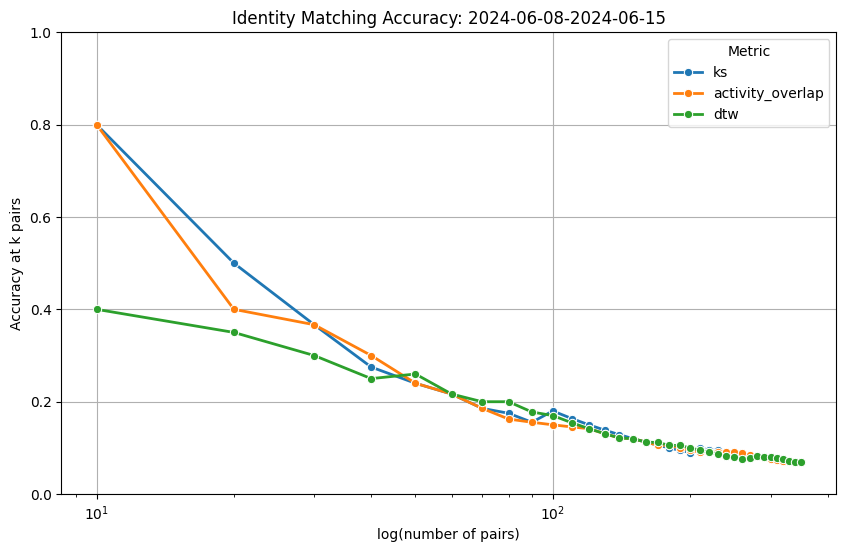

In [12]:

accuracy_df = pd.DataFrame(
    {
        "ks": accuracy_ks,
        "activity_overlap": accuracy_activity_overlap,
        "dtw": accuracy_dtw,
    },
    index=k_values[:len(accuracy_ks)],
)

# Melt the DataFrame to get it in a long format, which Seaborn prefers
accuracy_df = accuracy_df.reset_index().melt(id_vars="index", var_name="Metric", value_name="Accuracy")
accuracy_df.rename(columns={"index": "k_values"}, inplace=True)

# Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracy_df, x="k_values", y="Accuracy", hue="Metric", marker="o", linewidth=2)

# Customize the plot
plt.title(f"Identity Matching Accuracy: {'-'.join(TIME_PERIOD)}")
plt.xlabel("log(number of pairs)")
plt.ylabel("Accuracy at k pairs")
plt.ylim(0, 1)
plt.xscale("log")  # equivalent to logx=True
plt.grid(True)
plt.show()
